# Linear regression diagnostics

Four principal assumptions [1]:

1. Linearity 

2. Independence (Timely)

3. Homoscedasticity

4. Normality

Addtional assumption tests:

5. No (perfect) Multicollinearity

6. Outliers/Influence

OLS assuptions[4]:

1. Errors are uncorrelated.

2. Errors have a mean of 0 and a constant variance.

3. To make OLS the best estimator, residual follows a normal distribution.

modified from model_12_x1_diagn..

In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from ipywidgets import interact, interactive, IntSlider

In [2]:
data = pd. read_csv('train_wells_20210131_cln_bal.csv')
data=data[(data.DTCO<140) & (data.DTSM<240)]
data.describe()

,Depth,DTSM,DTCO,GAMMA,RHO
count,150625.000000,150625.000000,150625.000000,150625.000000,150625.000000
mean,8079.579824,132.023715,71.270285,82.517627,2.553487
std,3938.882276,34.998677,15.438664,44.815089,0.182163
min,559.000000,72.470100,40.459400,0.731000,1.223200
25%,5053.000000,104.310400,58.843400,46.972900,2.466800
50%,7877.000000,123.750900,70.195100,88.414200,2.589800
75%,11178.500000,151.105300,82.471600,111.434900,2.663100
max,18739.500000,239.998200,122.186300,623.161700,3.091600


In [3]:
cols=['DTCO']
X = data[['Depth']+cols]
Y = data[['DTSM']]

In [4]:
X_train0, X_test0, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [5]:
X_train = X_train0['DTCO']
X_test = X_test0['DTCO']

depth_train = X_train0['Depth']
depth_test = X_test0['Depth']

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(135562,) (135562, 1)
(15063,) (15063, 1)


## Linear regression with statsmodels



In [6]:
model = sm.OLS(Y_train,sm.add_constant(X_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DTSM   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 8.493e+05
Date:                Tue, 02 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:25:04   Log-Likelihood:            -5.3998e+05
No. Observations:              135562   AIC:                         1.080e+06
Df Residuals:                  135560   BIC:                         1.080e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0083      0.167   -108.100      0.000     -18.335     -17.682
DTCO           2.1053      0.002    921.570      0.000       2.101       2.110
==============================================================================
Omnibus:                     5045.261   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15248.855
Skew:                           0.057   Prob(JB):                         0.00
Kurtosis:                       4.639   Cond. No.                         344.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
obser = Y_train.DTSM
pred = results.fittedvalues
resid = results.resid
dtco = X_train

mean_res = np.mean(resid)
stdv_res = np.std(resid)

print("Residual mean:", mean_res)
print("Residual stdv:", stdv_res)


Residual mean: -6.190163695819465e-15
Residual stdv: 12.992090020722753


In [9]:
influence = OLSInfluence(results)


## Linearity


In [10]:
idx = np.random.choice(np.arange(len(pred)), 1000, replace=False)
resid_sample = resid.to_numpy()[idx]
pred_sample = pred.to_numpy()[idx]
obser_sample = obser.to_numpy()[idx]

pred_sort, resid_sort, obser_sort = zip(*sorted(zip(pred_sample, resid_sample, obser_sample)))
resid_sm = lowess(resid_sort,pred_sort)[:,1]
obser_sm = lowess(obser_sort,pred_sort)[:,1]

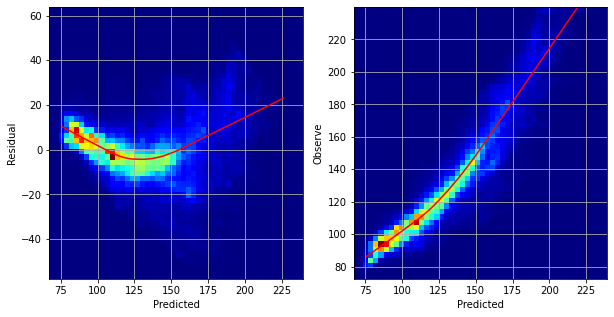

In [11]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.hist2d(pred, resid,bins=50, cmap='jet')
ax1.plot(pred_sort, resid_sm, color='red')
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Residual")
ax1.grid()

ax2.hist2d(pred, obser,bins=50, cmap='jet')
ax2.plot(pred_sort, obser_sm, color='red')
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Observe")
ax2.grid()
plt.show()

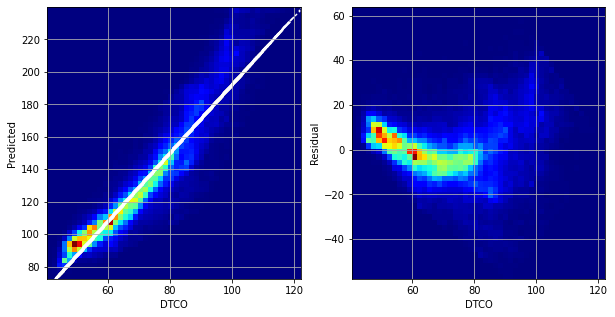

In [13]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for i, col in enumerate(cols):
  ax1.hist2d(X_train, obser, bins=50, cmap='jet')
  ax1.scatter(dtco, pred, s=0.5, color='white')
  ax1.set_xlabel(col)
  ax1.set_ylabel("Predicted")
  ax1.grid()

  ax2.hist2d(X_train, resid,bins=50, cmap='jet')
  ax2.set_xlabel(col)
  ax2.set_ylabel("Residual")
  ax2.grid()
plt.show()

Harvey-Collier multiplier test for Null hypothesis that the linear specification is correct

In [14]:
name = ['t value', 'p value']
test = sms.linear_harvey_collier(results)
lzip(name, test)


[('t value', 0.19218270482362235), ('p value', 0.847599380806912)]

Rainbow test

In [15]:
name = ['F statistic', 'p-value']
test = sms.linear_rainbow(results,frac=0.5)
lzip(name, test)

[('F statistic', 1.0062691879921284), ('p-value', 0.20795780797648059)]

White’s Two-Moment Specification Test

In [16]:
name = ['statistic', 'p-value','dof']
test = sms.diagnostic.spec_white(resid, model.exog)
lzip(name, test)

[('statistic', 12518.15073463967), ('p-value', 0.0), ('dof', 2)]

The p-values of Harvey-Collier multiplier test and rainbow test suggest that the null hypothesis is not rejected here. However p-value of spec white is small enough to suggest non-linearity in the data.

Residual plot also shows a parabolic trend (red). Polynomial curve fitting will be introduce with a squared term of **dtco**.


##Homoskedasticity tests
Breush-Pagan test

Ordinary least squares remains unbiased under heteroskedasticity, but efficiency is lost. [4]

In [17]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 18352.29047718477),
 ('p-value', 0.0),
 ('f-value', 21225.51542202143),
 ('f p-value', 0.0)]

Null hypothesis (of homoskedasticity) is rejected and heteroskedasticity assumed

Goldfeld-Quandt test

The standard deviation of the distribution is proportional to X.

In [18]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, model.exog)
lzip(name, test)

[('F statistic', 0.9959738209663944), ('p-value', 0.7002610824466664)]

Null hypothesis is not rejected. std is not proportional to variables.

## Normality of the residuals



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


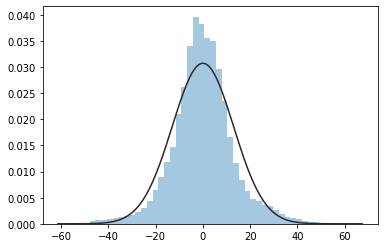

In [19]:
sns.distplot(resid, kde=False, fit=norm)

Jarque-Bera test:

In [20]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(results.resid)
lzip(name, test)


[('Jarque-Bera', 15248.854945775904),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.05655153914596329),
 ('Kurtosis', 4.639169490276407)]

Skewness is slightly positive, and a Kurtosis > 3 indicates higher probabilities at the mean and the tails than a normal distribution as the plot showing.

Omni test:

In [21]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(results.resid)
lzip(name, test)

[('Chi^2', 5045.260965687116), ('Two-tail probability', 0.0)]

Both tests reject the null hypothesis that the residual data are normally distributed.

QQ-plot:


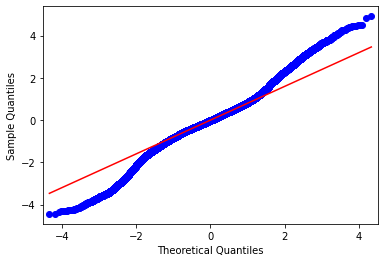

In [22]:
fig = sm.qqplot(results.resid, fit=True, line='q')

plt.show()

The data have more extrem values than expected as normal distriubted data. 

Test with another well log

In [23]:
data2 = pd. read_csv('test01_log.csv')
data2.head()

,Depth,DTCO,DTSM
0,4677.0,85.6295,141.6536
1,4677.5,85.6336,142.7486
2,4678.0,86.7785,145.4792
3,4678.5,88.8323,150.3114
4,4679.0,90.1820,155.5185


In [25]:
X1 = data2[['DTCO']].dropna(axis=0)
Y1 = data2.DTSM.values

In [32]:
sm.add_constant(X_train).shape

(135562, 2)

In [29]:
sm.add_constant(X1).shape

(14873, 2)

In [36]:
pred1 = results.predict(sm.add_constant(X1))

print('MSE: %.2f' % mean_squared_error(Y1, pred1))
print('R^2 Score: %.2f' % r2_score(Y1, pred1))

MSE: 230.70
R^2 Score: -0.20


In [37]:
# interactive

def trace_plot(st, intv):

  fig, (ax1, ax2) = plt.subplots(2,1,figsize=(25,8))

  ax1.plot(data2.Depth[st:st+intv], data2.DTSM[st:st+intv], color='blue', linewidth=1, label = 'real DTSM')
  ax1.plot(data2.Depth[st:st+intv], pred1[st:st+intv], color='red', linewidth=1, label='pred DTSM')
  ax1.grid()
  ax1.legend()
  
  ax1.set_ylabel("DTSM")

  ax2.plot(data2.Depth[st:st+intv], data2.DTCO[st:st+intv], color='green',linewidth=1,label = 'real DTCO')

  ax2.grid()
  ax2.legend()
  ax2.set_xlabel("Depth");
  ax2.set_ylabel("DTCO");


def trace_plot2(st, intv):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,10))

  ax1.plot(data2.DTSM[st:st+intv], data2.Depth[st:st+intv], color='blue', linewidth=1, label = 'real DTSM')
  ax1.plot(Y_pred2[st:st+intv], data2.Depth[st:st+intv], color='red', linewidth=1, label='pred DTSM')

  ax1.invert_yaxis()
  ax1.grid()
  ax1.legend()
  ax1.set_xlabel("DTSM")

  ax2.plot(data2.DTCO[st:st+intv], data2.Depth[st:st+intv], color='green',linewidth=1,label = 'real DTCO')

  ax2.invert_yaxis()
  ax2.grid()
  ax2.set_xlabel("DTCO")
  ax2.set_ylabel([])


In [41]:
topmax=len(data2)-100
interactive(trace_plot, st=IntSlider(min=0, max=topmax, value=0, step=100, description="Top"),
                        intv=IntSlider(min=200, max=topmax, value=topmax, step=100, description="Inteval")
                        )

interactive(children=(IntSlider(value=0, description='Top', max=14773, step=100), IntSlider(value=14773, descr…

## Reference
[1] 
https://people.duke.edu/~rnau/testing.htm

[2]
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html

[3]
https://www.statsmodels.org/stable/diagnostic.html

[4]
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0

[5]
https://github.com/rorytboyle/hierarchical_regression/blob/master/regression_diagnostics.py


